# Preparación de datos
## Limpieza

In [5]:
import pandas as pd
import numpy as np

data = pd.read_csv('train.csv', parse_dates=['date'])

print(data.head())

        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10


In [6]:
print(data.isnull().sum())

date     0
store    0
item     0
sales    0
dtype: int64


## Transformación de datos

In [7]:
data['date'] = pd.to_datetime(data['date'])


data.set_index('date', inplace=True)

In [8]:

data.sort_index(inplace=True)

# Preprocesamiento de datos
## División de series temporales

In [22]:
print(f"Fecha máxima en el conjunto de datos: {data.index.max()}")

Fecha máxima en el conjunto de datos: 2017-12-31 00:00:00


In [24]:
train_end = '2017-06-30'  
val_end = '2017-09-30'    
test_end = '2017-12-31'   

train = data[:train_end]
val = data[train_end:val_end]
test = data[val_end:test_end]

## Generación de secuencias:

In [25]:
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)

In [26]:
X_train, y_train = [], []
X_val, y_val = [], []

store_item_combinations = data.groupby(['store', 'item']).groups.keys()

for store, item in store_item_combinations:
    df_store_item = train[(train['store'] == store) & (train['item'] == item)]
    
    X_si, y_si = create_sequences(df_store_item[['sales']], df_store_item['sales'])
    X_train.extend(X_si)
    y_train.extend(y_si)
    
    df_store_item_val = val[(val['store'] == store) & (val['item'] == item)]
    X_si_val, y_si_val = create_sequences(df_store_item_val[['sales']], df_store_item_val['sales'])
    X_val.extend(X_si_val)
    y_val.extend(y_si_val)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)


# Selección de modelo

# Arquitectura del modelo

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Definir el modelo
model = Sequential()
model.add(LSTM(units=64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compilar el modelo
model.compile(loss='mean_squared_error', optimizer='adam')

# Entrenamiento del modelo

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stop])


Epoch 1/50
26625/26625 [==============================] - 182s 7ms/step - loss: 159.3097 - val_loss: 86.9425
Epoch 2/50
26625/26625 [==============================] - 172s 6ms/step - loss: 84.1820 - val_loss: 83.0716
Epoch 3/50
26625/26625 [==============================] - 171s 6ms/step - loss: 80.7253 - val_loss: 86.8546
Epoch 4/50
26625/26625 [==============================] - 172s 6ms/step - loss: 78.4123 - val_loss: 80.8179
Epoch 5/50
26625/26625 [==============================] - 172s 6ms/step - loss: 76.6498 - val_loss: 81.7473
Epoch 6/50
26625/26625 [==============================] - 171s 6ms/step - loss: 75.7398 - val_loss: 82.1238
Epoch 7/50
26625/26625 [==============================] - 171s 6ms/step - loss: 74.9047 - val_loss: 80.3520
Epoch 8/50
26625/26625 [==============================] - 169s 6ms/step - loss: 74.1308 - val_loss: 78.9719
Epoch 9/50
26625/26625 [==============================] - 171s 6ms/step - loss: 73.8463 - val_loss: 80.5436
Epoch 10/50
26625/26625 [==

# Evaluación del modelo

In [27]:
X_test, y_test = [], []
time_steps = 30 

for store, item in store_item_combinations:

    df_train_val = data[(data['store'] == store) & (data['item'] == item) & (data.index <= val_end)]
    

    df_test = data[(data['store'] == store) & (data['item'] == item) & (data.index > val_end) & (data.index <= test_end)]
    
 
    if df_test.empty:
        continue 
    

    df_combined = pd.concat([df_train_val.tail(time_steps), df_test])
    
  
    X_si_test, y_si_test = create_sequences(df_combined[['sales']], df_combined['sales'], time_steps)
    
   
    if len(X_si_test) == 0:
        continue  
    
    X_test.extend(X_si_test)
    y_test.extend(y_si_test)

In [28]:
X_test = np.array(X_test)
y_test = np.array(y_test)

print(f"Forma de X_test: {X_test.shape}")
print(f"Número de muestras en X_test: {len(X_test)}")


Forma de X_test: (46000, 30, 1)
Número de muestras en X_test: 46000


In [31]:

X_test, y_test = [], []

for store, item in store_item_combinations:
    df_store_item_test = test[(test['store'] == store) & (test['item'] == item)]
    X_si_test, y_si_test = create_sequences(df_store_item_test[['sales']], df_store_item_test['sales'])
    X_test.extend(X_si_test)
    y_test.extend(y_si_test)

X_test = np.array(X_test)
y_test = np.array(y_test)


y_pred = model.predict(X_test)


from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")


MAE: 6.765510256812686
MSE: 79.55211242120521
RMSE: 8.919199090793143


# Ajuste de hiperparámetros

In [32]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(1))

# Forecasting

In [34]:
forecast_period = 90
forecasts = {}

for store, item in store_item_combinations:
    df_store_item = data[(data['store'] == store) & (data['item'] == item)]
    recent_data = df_store_item[['sales']].values[-X_train.shape[1]:].astype(np.float32)
    X_input = recent_data.reshape(1, X_train.shape[1], 1)
    temp_input = list(X_input[0])
    lst_output = []
    i = 0
    while(i < forecast_period):
        if(len(temp_input) > X_train.shape[1]):
            temp_input = temp_input[1:]
        input_data = np.array(temp_input).reshape(1, X_train.shape[1], 1).astype(np.float32)
        yhat = model.predict(input_data, verbose=0)
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i += 1
    forecasts[(store, item)] = lst_output

C:\Users\caste\AppData\Local\Temp\ipykernel_30308\376680636.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_data = np.array(temp_input).reshape(1, X_train.shape[1], 1).astype(np.float32)
C:\Users\caste\AppData\Local\Temp\ipykernel_30308\376680636.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_data = np.array(temp_input).reshape(1, X_train.shape[1], 1).astype(np.float32)
C:\Users\caste\AppData\Local\Temp\ipykernel_30308\376680636.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-

# Visualización

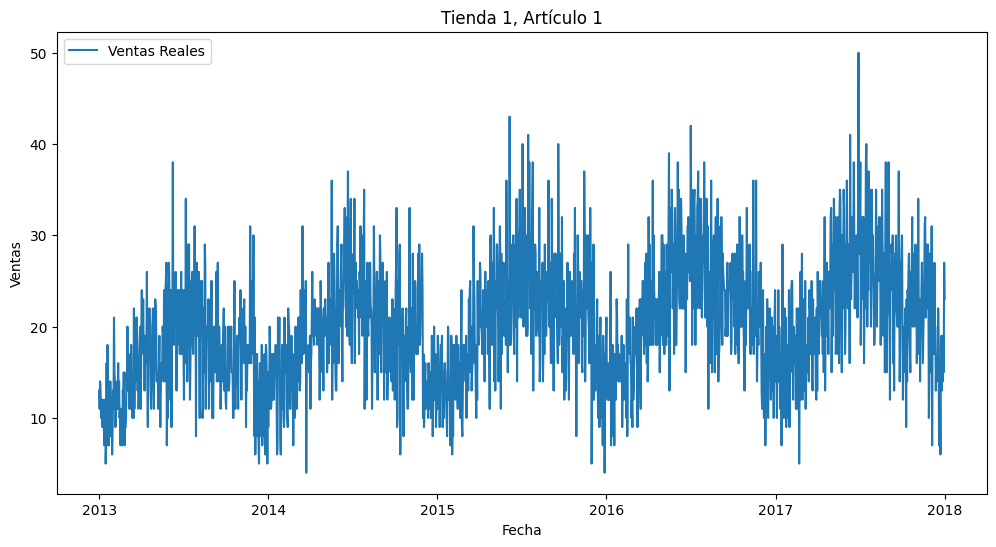

In [52]:
import matplotlib.pyplot as plt

store, item = 1, 1
forecast = forecasts[(store, item)]

last_date = data.index.max()
forecast_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=forecast_period)

actual_sales = data[(data['store'] == store) & (data['item'] == item)]['sales']

plt.figure(figsize=(12,6))
plt.plot(actual_sales.index, actual_sales.values, label='Ventas Reales')
plt.title(f'Tienda {store}, Artículo {item}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

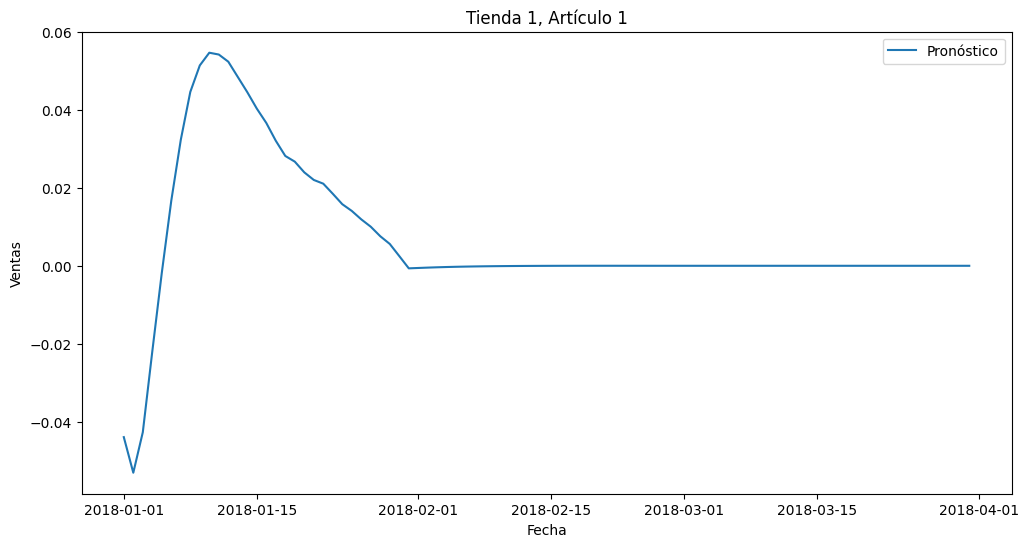

In [51]:
plt.figure(figsize=(12,6))
plt.plot(forecast_dates, forecast, label='Pronóstico', zorder=5)
plt.title(f'Tienda {store}, Artículo {item}')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.legend()
plt.show()

# Interpretabilidad del modelo

In [92]:
import shap
# por problemas de compatibilidad esta instruccion no se pudo ejecutar

# Crear el explainer
explainer = shap.KernelExplainer(model.predict, X_train[:100])

# Calcular los valores SHAP
shap_values = explainer.shap_values(X_test[:10])

# Visualizar
shap.summary_plot(shap_values, X_test[:10])


Provided model function fails when applied to the provided data set.


ValueError: Calling `Model.predict` in graph mode is not supported when the `Model` instance was constructed with eager mode enabled. Please construct your `Model` instance in graph mode or call `Model.predict` with eager mode enabled.

1. ¿Cuál es el problema del gradiente de fuga en las redes LSTM y cómo afecta la efectividad de LSTM para el
pronóstico de series temporales?

El problema del gradiente de fuga en redes LSTM ocurre cuando los gradientes se vuelven extremadamente pequeños durante la retropropagación, lo que impide que el modelo aprenda relaciones a largo plazo. Esto afecta la efectividad de LSTM en el pronóstico de series temporales al limitar su capacidad para capturar dependencias a largo plazo, haciendo que el modelo se enfoque más en patrones recientes.

2. ¿Cómo se aborda la estacionalidad en los datos de series temporales cuando se utilizan LSTM para realizar
pronósticos y qué papel juega la diferenciación en el proceso?

La estacionalidad en series temporales se maneja proporcionando al modelo información que capture ciclos repetitivos (por ejemplo, añadiendo características adicionales como mes o día de la semana) o mediante la diferenciación, que transforma los datos eliminando tendencias y estacionalidad, permitiendo que el LSTM se concentre en aprender los cambios más importantes.

3. ¿Cuál es el concepto de "tamaño de ventana" en el pronóstico de series temporales con LSTM y cómo
afecta la elección del tamaño de ventana a la capacidad del modelo para capturar patrones a corto y largo
plazo?

El "tamaño de ventana" en el pronóstico de series temporales con LSTM se refiere a la longitud de la secuencia de datos históricos utilizada para predecir el valor futuro. Un tamaño de ventana corto puede capturar patrones a corto plazo, mientras que uno más largo puede ayudar a capturar dependencias a largo plazo, aunque elegir un tamaño demasiado grande podría introducir ruido innecesario en los datos.